In [385]:
import torch 
from matplotlib import pyplot as plt 
from tkgdti.train.utils import device_and_data_loading
import argparse 
from tkgdti.data.TriplesDatasetGNN import TriplesDatasetGNN
from tkgdti.data.process_graph import process_graph
import torch_geometric as pyg
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [388]:
FOLD = 0 
UID = '575bf710-ed8e-438b-b45e-1b6ce8d70b73'

#model = torch.load(f'/home/teddy/local/TKG-DTI/output/tkg/GNN/FOLD_{FOLD}/{UID}/best_model.pt').cpu()
model = torch.load(f'/home/teddy/local/TKG-DTI/output/tmp/69dfefd6-46d4-4a2a-9bfe-39fb25b2f09a/best_model.pt').cpu()
model.eval()

preds = pd.read_csv(f'/home/teddy/local/TKG-DTI/output/tmp/69dfefd6-46d4-4a2a-9bfe-39fb25b2f09a/predictions.csv')
preds.head()

args            = argparse.Namespace() 
args.data       = f'/home/teddy/local/TKG-DTI/data/tkg/processed/FOLD_{FOLD}/'
args.verbose    = True

device, data, train_triples, valid_triples, \
        valid_neg_triples, test_triples, test_neg_triples  = device_and_data_loading(args, return_test=True)

tdata = process_graph(data)

edge_index_dict = {key: tdata[key]['edge_index'] for key in tdata.metadata()[1]}
num_node_dict = {key: tdata[key].num_nodes for key in tdata.metadata()[0]}


device: cuda


/home/teddy/local/TKG-DTI/tkgdti/data/process_graph.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tdata[key].edge_index = torch.tensor(edge_index, dtype=torch.long)


In [389]:
import copy 

class TKGExplainer(): 

    def __init__(self, model, data): 
        self.model = model 
        self.data = data 
        self.tdata = process_graph(data)

    def _get_obs(self, drug_idx): 
        ''' 
        Convert heterogenous graph (self.data) to a homogenous graph for input to model with the relevant drug_idx set to 1 (diffusion source)

        args: 
            drug_idx        int         the heterogenous drug index to make predictions for 

        returns: 
            homogenous graph with the relevant `drug_idx` input value (x) set to 1 
        '''

        # set all inputs to zero 
        x_dict = {node:torch.zeros((num_nodes, 1), dtype=torch.float32) for node, num_nodes in num_node_dict.items()}

        # set relevant drug idx input value to 1 (diffusion source)
        x_dict['drug'][drug_idx] = torch.ones((1,), dtype=torch.float32)

        # add relevant attributes to obs 
        obs = pyg.data.HeteroData()

        for node_type in x_dict:
            obs[node_type].x = x_dict[node_type]
            obs[node_type].num_nodes = x_dict[node_type].shape[0]
            obs[node_type].names = self.tdata[node_type].names
            assert obs[node_type].num_nodes == len(obs[node_type].names), 'Number of nodes and names do not match'

        edge_index_dict =  {key: self.tdata[key]['edge_index'] for key in self.tdata.metadata()[1]}
        for edge_type in edge_index_dict:
            src_type, relation, dst_type = edge_type
            obs[(src_type, relation, dst_type)].edge_index = edge_index_dict[edge_type]

        homo_obs = copy.deepcopy( obs.to_homogeneous() )

        ############# node offsets #############
        # hetero node index + offset = homo node index 
        node_offsets = {} 
        ii = 0
        for ntype in obs.metadata()[0]: 
            node_offsets[ntype] = ii 
            ii += obs[ntype].num_nodes
        ########################################

        return homo_obs, obs, node_offsets 
    
    

    def explain(self, drug_name, prot_name, edge_size=5e-4, epochs=250, lr=1e-2, topK=50, relation=('drug', 'targets', 'gene')): 

        drug_ntype, dti_relation, prot_ntype = relation

        drug_idx = self.tdata[drug_ntype].names.tolist().index(drug_name)
        prot_idx = self.tdata[prot_ntype].names.tolist().index(prot_name)

        homo_obs, hetero_obs, node_offsets = self._get_obs(drug_idx)

        homo_drug_idx = drug_idx + node_offsets[drug_ntype]
        homo_prot_idx = prot_idx + node_offsets[prot_ntype]

        ###########################################################################################
        ## ensure that there is not an DTI edge between drug and protein (novel predictions)
        dti_edge_mask = homo_obs.edge_type == hetero_obs.metadata()[1].index(relation)
        assert ((homo_obs.edge_index[0][dti_edge_mask] == homo_drug_idx) & (homo_obs.edge_index[1][dti_edge_mask] == homo_prot_idx)).sum() == 0, 'There exists a DTI edge for this drug->protein, if explaining a training set, make sure to remove the relevant edge first'
        ###########################################################################################

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = copy.deepcopy(self.model).to(device)
        model.eval() 
        explainer = Explainer(
                                model=model,
                                algorithm=pyg.explain.GNNExplainer(edge_size    = edge_size, 
                                                                    epochs      = epochs, 
                                                                    lr          = lr),
                                explanation_type='model',
                                edge_mask_type='object',
                                model_config=dict(
                                    mode='binary_classification',
                                    task_level='node',
                                    return_type='raw',
                                ),
                            )

        explanation = explainer(x           = homo_obs.x.to(device), 
                                edge_index  = homo_obs.edge_index.to(device), 
                                edge_type   = homo_obs.edge_type.to(device), 
                                index       = homo_prot_idx)
        
        # convert explanation back to hetero graph 
        hetero_expl = copy.deepcopy(hetero_obs)
        mask_threshold = torch.sort(explanation.edge_mask).values[-(topK + 1)]
        for i, edge_type in enumerate(hetero_obs.metadata()[1]):
            
            edge_type_mask = homo_obs.edge_type == i
            hetero_expl[edge_type].edge_mask = explanation.edge_mask[edge_type_mask]

            # filter to top K edges 
            keep_mask = (hetero_expl[edge_type].edge_mask > mask_threshold).cpu()
            hetero_expl[edge_type].edge_index = hetero_expl[edge_type].edge_index[:, keep_mask]
            hetero_expl[edge_type].edge_mask = hetero_expl[edge_type].edge_mask[keep_mask]

        hetero_expl.DRUG_IDX = drug_idx 
        hetero_expl.PROT_IDX = prot_idx 
        hetero_expl.RELATION = relation

        return hetero_expl
    


In [390]:

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_explanation(expl, node_labels_on_right=False, only_plot_paths=True, node2name={}):
    """
    Plots the subgraph in 'expl' (a HeteroData explanation object) as a colored NetworkX graph.
    
    - Nodes are colored by their PyG node type (e.g., 'drug', 'gene', 'dbgap_subject', etc.).
    - Edges are colored by their relation name (the middle element of (src_type, rel, dst_type)).
    - Only edges with edge_mask > 0 are retained (others are ignored).
    - If node_labels_on_right=True, node labels are placed in a vertical list on the plot's right side.
    - Otherwise, node labels appear in their usual position near each node.
    - Includes a legend showing the color mapping for node types and edge types.
    """
    
    # ------------------------
    # 1) Build a DiGraph
    # ------------------------
    G = nx.DiGraph()

    for key in expl.metadata()[1]: 
        edge_index = expl[key].edge_index
        edge_mask = expl[key].edge_mask

        if edge_index.shape[1] == 0: 
            continue
        
        src_idx = edge_index[0].view(-1).detach().cpu().numpy()
        dst_idx = edge_index[1].view(-1).detach().cpu().numpy()

        src_names = np.array(expl[key[0]].names)[src_idx].tolist()
        dst_names = np.array(expl[key[2]].names)[dst_idx].tolist()

        if key[0] in node2name:
            src_names = [node2name[key[0]][name] for name in src_names]
        if key[2] in node2name:
            dst_names = [node2name[key[2]][name] for name in dst_names]

        # add src nodes with ntype attribute 
        for i, src_name in enumerate(np.unique(src_names)):
            G.add_node(src_name, ntype=key[0])

        # add dst nodes with ntype attribute
        for i, dst_name in enumerate(np.unique(dst_names)):
            G.add_node(dst_name, ntype=key[2])

        for i, (src, dst, mask) in enumerate(zip(src_names, dst_names, edge_mask)):
            G.add_edge(src, dst, weight=mask, rel=key[1])


    # find nodes that don't have an ntype attr 
    for node in G.nodes():
        if 'ntype' not in G.nodes[node]:
            print(node)

    if only_plot_paths: 
        # Only keep nodes on a path from src_node to targ_node
        src_idx = expl.DRUG_IDX
        targ_idx = expl.PROT_IDX
        drug_ntype, _, prot_ntype = expl.RELATION

        src_node = expl[drug_ntype].names[src_idx]
        targ_node = expl[prot_ntype].names[targ_idx]

        if drug_ntype in node2name:
            src_node = node2name[drug_ntype][src_node]
        if prot_ntype in node2name:
            targ_node = node2name[prot_ntype][targ_node]

        path_nodes = set()
        for path in nx.all_simple_paths(G, source=src_node, target=targ_node):
            path_nodes.update(path)
        G = G.subgraph(path_nodes)


    # ------------------------
    # 2) Layout via Graphviz
    # ------------------------
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=TB')

    plt.figure(figsize=(8, 6))

    # ------------------------
    # 3) Color Nodes by Type
    # ------------------------
    # Define whatever node-type → color mapping you prefer:
    node_type_colors = {
        "drug":          "#d62728",  # red
        "gene":          "#1f77b4",  # blue
        "dbgap_subject": "gray",
        "disease":       "green",
        "pathway":       "orange",
    }
    fallback_color = "black"

    # Prepare color list in the same order as G.nodes()
    node_list = list(G.nodes(data=True))  # each item => (node_name, dict_of_attrs)
    node_colors = []
    for node_name, attrs in node_list:
        ntype = attrs['ntype']  # e.g. 'drug', 'gene', etc.
        node_colors.append(node_type_colors.get(ntype, fallback_color))

    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[x[0] for x in node_list],
        node_color=node_colors,
        node_size=300,
        node_shape='s',
        alpha=0.75
    )

    # ------------------------
    # 4) Color Edges by Relation
    # ------------------------
    edge_list = list(G.edges(data=True))
    # We'll build a palette and assign each distinct relation a color
    palette = [
        "#2ca02c", "#ff7f0e", "#9467bd", "#8c564b", "#e377c2",
        "#7f7f7f", "#bcbd22", "#17becf"
    ]
    edge_color_map = {}
    color_idx = 0

    edge_colors = []
    edge_widths = []
    for (u, v, d) in edge_list:
        rel_name = d['rel']
        if rel_name not in edge_color_map:
            edge_color_map[rel_name] = palette[color_idx % len(palette)]
            color_idx += 1
        edge_colors.append(edge_color_map[rel_name])
        edge_widths.append(d['weight'])  # use mask value as width

    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v) for (u, v, _) in edge_list],
        width=3*edge_widths,
        arrows=True,
        arrowstyle='->',
        arrowsize=20,
        alpha=0.9,
        edge_color=edge_colors
    )

    # ------------------------
    # 5) Node Labels
    # ------------------------
    if not node_labels_on_right:
        # Normal in-place labels
        nx.draw_networkx_labels(G, pos, font_size=7)
    else:
        # Place labels in a vertical list on the right, with lines back to each node
        xs = [p[0] for p in pos.values()]
        min_x, max_x = min(xs), max(xs)
        graph_width = max_x - min_x if len(xs) > 1 else 1.0

        # Sort nodes by descending y to lay them out top→bottom
        sorted_node_names = sorted(G.nodes(), key=lambda n: pos[n][1], reverse=True)
        ys = [pos[n][1] for n in sorted_node_names]
        max_y_node, min_y_node = max(ys), min(ys)
        vertical_extent = max_y_node - min_y_node if len(ys) > 1 else 1

        n_nodes = len(sorted_node_names)
        if n_nodes > 1:
            node_label_spacing = 0.66 * (vertical_extent / (n_nodes - 1))
        else:
            node_label_spacing = 0.1

        label_offset_x = max_x + 0.3 * graph_width

        # Draw each label
        for i, n in enumerate(sorted_node_names):
            label_y = max_y_node - i * node_label_spacing
            plt.annotate(
                n,
                xy=pos[n],
                xytext=(label_offset_x, label_y),
                arrowprops=dict(
                    arrowstyle="-",
                    alpha=0.2,
                    shrinkA=0,
                    shrinkB=0,
                    color='black'
                ),
                va='center',
                fontsize=7
            )

    # ------------------------
    # 6) Legend
    # ------------------------
    # Node type legend
    node_legend_patches = []
    for ntype, color in node_type_colors.items():
        node_legend_patches.append(mpatches.Patch(color=color, label=ntype))

    # Edge relation legend
    edge_legend_lines = []
    for rel_name, color in edge_color_map.items():
        edge_legend_lines.append(mlines.Line2D([], [], color=color, label=rel_name))

    plt.legend(
        handles=node_legend_patches + edge_legend_lines,
        bbox_to_anchor=(0.05, 1),
        borderaxespad=0.
    )

    plt.margins(x=0.1)
    plt.axis('off')
    plt.show()


In [391]:
preds[lambda x: x.negatives].sort_values('prob', ascending=False).head(10)

,drug,protein,score,prob,drug_name,prot_name,train,valid,test,negatives
1173010,82,82,0.592190,0.592190,YYLKKYCXAOBSRM-JXMROGBWSA-N,ABL2,False,False,False,True
233836,16,4972,0.434235,0.434235,FPOHNWQLNRZRFC-ZHACJKMWSA-N,HDAC11,False,False,False,True
1133639,79,3623,0.372321,0.372321,XYFPWWZEPKGCCK-GOSISDBHSA-N,ERBB2,False,False,False,True
229911,16,1047,0.368968,0.368968,FPOHNWQLNRZRFC-ZHACJKMWSA-N,AURKB,False,False,False,True
1062119,74,3623,0.336128,0.336128,WVUNYSQLFKLYNI-AATRIKPKSA-N,ERBB2,False,False,False,True
410044,28,9532,0.301609,0.301609,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,PIK3CB,False,False,False,True
933802,65,4042,0.281088,0.281088,UHTHHESEBZOYNR-UHFFFAOYSA-N,FLT4,False,False,False,True
833672,58,4040,0.275170,0.275170,PHXJVRSECIGDHY-UHFFFAOYSA-N,FLT3,False,False,False,True
933383,65,3623,0.265997,0.265997,UHTHHESEBZOYNR-UHFFFAOYSA-N,ERBB2,False,False,False,True
520934,36,5990,0.245194,0.245194,KTUFNOKKBVMGRW-UHFFFAOYSA-N,KIT,False,False,False,True


In [394]:
expl = TKGExplainer(model, data)
explanation = expl.explain('YYLKKYCXAOBSRM-JXMROGBWSA-N', 'ABL2', topK=100, lr=1e-2)

/home/teddy/local/TKG-DTI/tkgdti/data/process_graph.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tdata[key].edge_index = torch.tensor(edge_index, dtype=torch.long)


AttributeError: 'GNN' object has no attribute 'norm'

ValueError: min() arg is an empty sequence

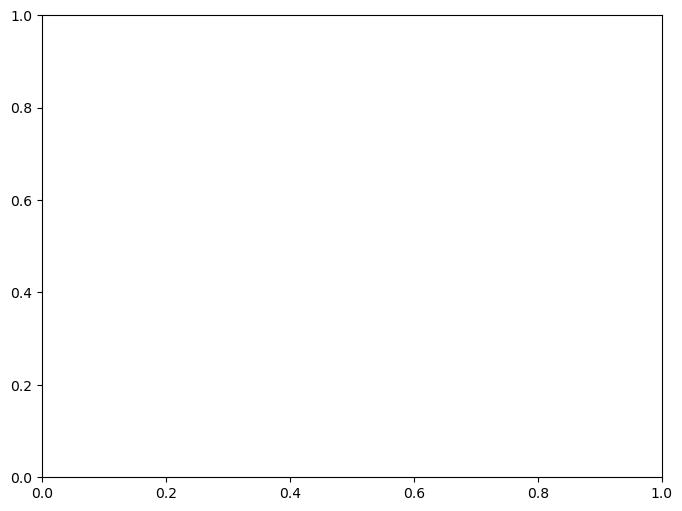

In [393]:
inchi2name = {'drug': pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')[['inhibitor', 'inchikey']].drop_duplicates().set_index('inchikey').to_dict()['inhibitor']}
plot_explanation(explanation, node_labels_on_right=True, only_plot_paths=True, node2name=inchi2name)

In [356]:
atts = []
for i, conv in enumerate(model.convs):
    atts2 = []
        
    for i in range(model.edge_embedding.weight.shape[0]): 
        edge_embed = model.edge_embedding.weight[i].unsqueeze(0) 

        edge_attr = conv.lin_edge(edge_embed)
        edge_attr = edge_attr.view(-1, conv.heads, conv.out_channels)
        alpha_edge = (edge_attr * conv.att_edge).sum(dim=-1)
        atts2.append(alpha_edge.item())
    
    atts.append(atts2)

edge_att = pd.DataFrame(np.array( atts ), index=[f'conv_{i}' for i in range(len(atts))], columns = [x[1] for x in tdata.metadata()[1]]) 
edge_att = edge_att.unstack().reset_index().rename({'level_0':'edge_type', 'level_1':'layer', 0:'att_score'}, axis=1)
edge_att.head() 


,edge_type,layer,att_score
0,mut_missense_variant_deleterious_fwd,conv_0,-0.432222
1,mut_missense_variant_deleterious_fwd,conv_1,-0.224037
2,mut_missense_variant_deleterious_fwd,conv_2,2.041021
3,PHH_lincs_perturbation_rev,conv_0,-1.808859
4,PHH_lincs_perturbation_rev,conv_1,1.236724


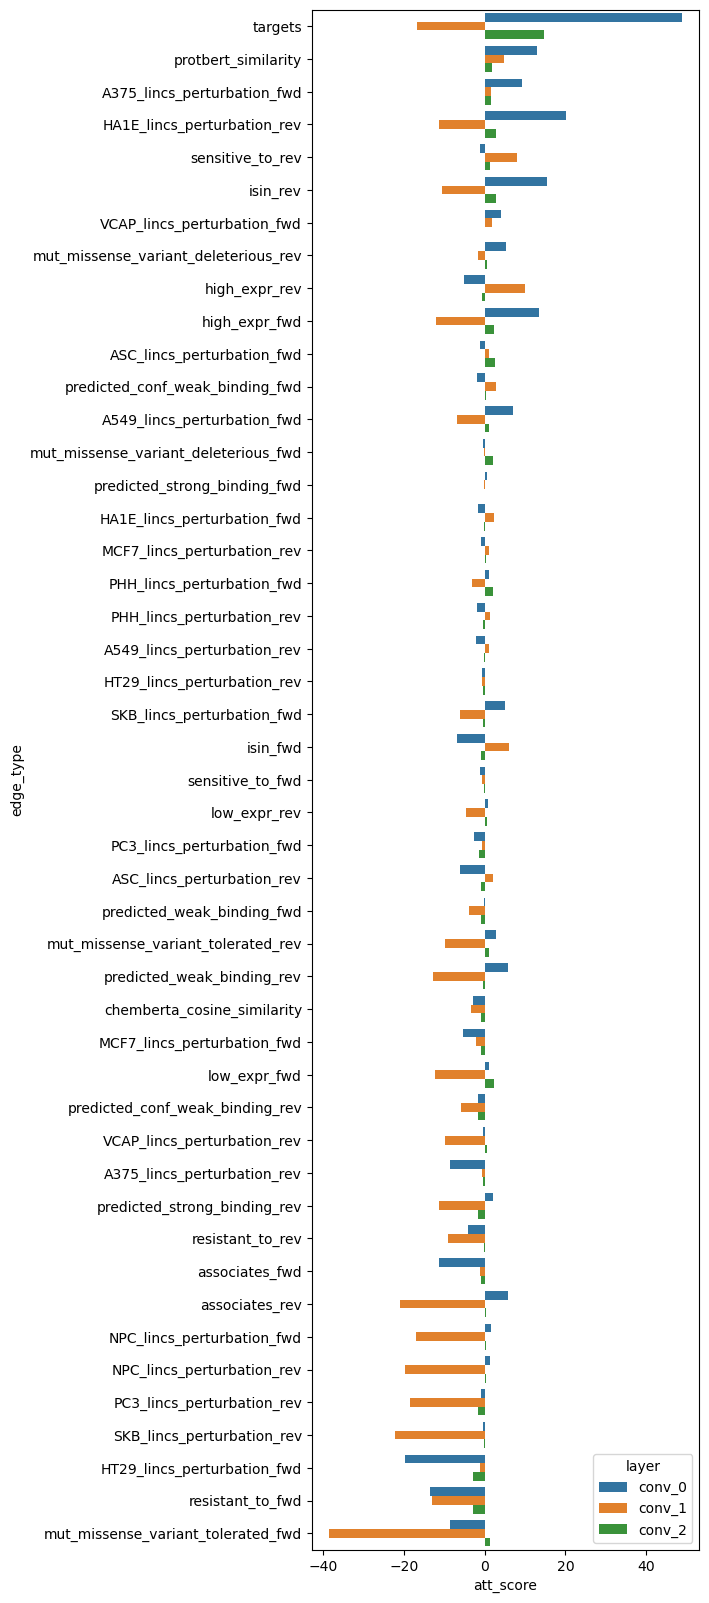

In [368]:
import seaborn as sbn 

plt.figure(figsize=(5, 20)) 
# rotate the plot 

sbn.barplot(data=edge_att, y='edge_type', x='att_score', hue='layer', order=edge_att.groupby('edge_type').att_score.mean().sort_values(ascending=False).index, orient='h')
# make x label vertical
#plt.xticks(rotation=90)

plt.show()

array([[-4.32222366e-01, -1.80885875e+00, -5.58546066e-01,
        -2.67718124e+00,  9.33310890e+00,  5.90893364e+00,
        -5.18777037e+00, -9.95947242e-01, -2.05533457e+00,
        -8.99985954e-02,  2.00348625e+01, -1.02067959e+00,
         2.83738899e+00,  1.54222059e+01, -1.04501534e+00,
        -6.02240229e+00,  7.85267353e-01, -1.96558838e+01,
        -1.85335910e+00,  5.68754959e+00, -1.60482013e+00,
        -4.18447590e+00,  6.98146915e+00, -1.12505617e+01,
         1.29269352e+01, -1.36137600e+01,  2.17188692e+00,
         4.16261053e+00, -2.95156050e+00, -1.23380947e+00,
        -1.10678792e+00,  1.05312431e+00, -6.76657820e+00,
         4.87807846e+01,  5.37371731e+00, -8.49125862e+00,
        -5.24672866e-01, -1.76175082e+00,  1.28782356e+00,
         1.49138737e+00, -8.68094730e+00,  4.91940784e+00,
         6.92684293e-01, -3.35249603e-01,  1.35642319e+01,
        -5.29861546e+00,  1.20537317e+00],
       [-2.24036992e-01,  1.23672402e+00, -5.82074404e-01,
        -6.23

In [341]:
model.convs[0].att_edge #(model.edge_embedding.weight).size()

Parameter containing:
tensor([[[ 2.5626e-01,  1.1107e+00,  3.0429e-01, -4.5122e-04,  7.3609e-01,
          -6.1914e-01, -4.7488e-01, -8.4524e-02,  6.2100e-01,  6.1339e-01,
           2.4529e-01,  6.7132e-01]]], requires_grad=True)

In [ ]:
model

In [334]:
edge_att = get_edge_attention_offsets(model)


AttributeError: 'GATConv' object has no attribute 'att_e'

In [330]:
model.convs

ModuleList(
  (0-2): 3 x GATConv(12, 12, heads=1)
)

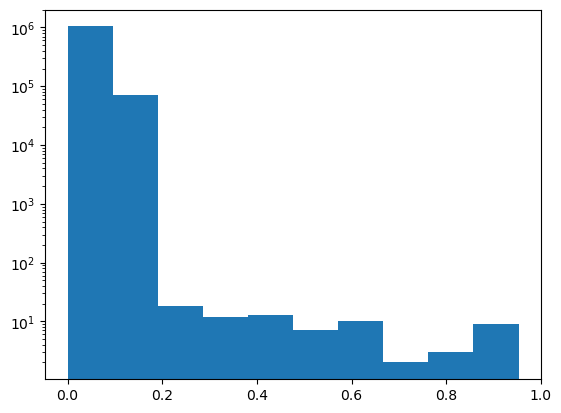

In [205]:
plt.figure()
plt.hist(explanation.edge_mask.detach().cpu().numpy(), bins=10) 
plt.yscale('log')
plt.show()

In [191]:
src, dst = homo.edge_index
((src == 4630) & (dst == 8277)).sum()

tensor(0)

In [177]:

dti_edge_type = hetero.metadata()[1].index( ('drug','targets','gene'))
dti_edge_mask = homo.edge_type == dti_edge_type 
dti_edge_index = homo.edge_index[:, dti_edge_mask]
dti_edge_index[:, :5]

tensor([[ 4591,  4566,  4570,  4585,  4585],
        [ 5764,  6328,  6341, 14774, 14775]])

In [186]:
node_offsets = {} 
ii = 0
for ntype in hetero.metadata()[0]: 
    node_offsets[ntype] = ii 
    ii += hetero[ntype].num_nodes

node_offsets


{'dbgap_subject': 0,
 'disease': 470,
 'drug': 4565,
 'gene': 4654,
 'pathway': 18958}

In [187]:
hetero['drug','targets','gene'].edge_index[:, :5] + torch.tensor([[4565],
                                                                  [4654]])

tensor([[ 4591,  4566,  4570,  4585,  4585],
        [ 5764,  6328,  6341, 14774, 14775]])

In [162]:
tdata['gene'].names.tolist().index('ERBB2')

3623

In [150]:
src,dst = tdata['drug', 'targets', 'gene'].edge_index
contains_dti = (src == drug_idx) & (dst == prot_idx)
contains_dti.sum()
# tdata doesn't contain the dti, so some mix up in the conversion between hetero->homo

tensor(0)

In [153]:
len(tdata['gene'].names)

14304

In [152]:
dst.max()

tensor(13816)

In [ ]:
# didx=4,9,12 
model.to(device)
model.eval()

drug_idx = 65
prot_idx = 3623

protein_idxs = tdata.metadata()[0].index('gene')
dat = datas[drug_idx].to_homogeneous()
model.eval()
with torch.no_grad():
    out = model(dat.x.to(device), dat.edge_index.to(device), dat.edge_type.to(device))
prot_mask = dat.node_type == protein_idxs

prot_probs = out[prot_mask] 
#prot_probs = out[prot_idx] 

# convert prot_idx to global idx
rng = torch.arange(out.size(0))
targ_idx = rng[prot_mask][prot_idx]

# convert drug_idx to global idx 
src_idx = dat.x[:, 0].nonzero().squeeze()

print('drug_idx:', drug_idx)
print('prot_idx:', prot_idx)
print('drug name:', tdata['drug'].names[drug_idx])
print('prot name:', tdata['gene'].names[prot_idx])
print('prot_idx prob (target):', prot_probs[prot_idx])  # larger probs will probably work better 
print('targ_idx:', targ_idx)
print('src_idx:', src_idx)

assert out[targ_idx] == prot_probs[prot_idx], 'something went wrong'

drug_idx: 65
prot_idx: 3623
drug name: UHTHHESEBZOYNR-UHFFFAOYSA-N
prot name: ERBB2
prot_idx prob (target): tensor([0.3969], device='cuda:0')
targ_idx: tensor(8277)
src_idx: tensor(4630)


In [132]:
src,dst = dat.edge_index.detach().cpu()
contains_dti = (src == src_idx.cpu()) & (dst == targ_idx.cpu())
contains_dti.sum()

tensor(2)

In [136]:
dat.edge_index[:, contains_dti]

tensor([[4596, 4596],
        [8277, 8277]])

In [145]:
# WHY DOES THE GRAPH HAVE A DTI but it's not in targetome!?
np.array(tdata.metadata()[1])[dat.edge_type[contains_dti]]

array([['drug', 'targets', 'gene'],
       ['drug', 'predicted_strong_binding_fwd', 'gene']], dtype='<U36')

In [142]:
targ = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')
targ[lambda x: (x.inchikey == tdata['drug'].names[drug_idx])]# & (x.Symbol == tdata['gene'].names[prot_idx])]

,inhibitor,Symbol,GeneID,targetome_adj_tier,can_smiles,inchikey,iso_smiles
41,Vandetanib (ZD6474),ABL1,25,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
106,Vandetanib (ZD6474),RIPK2,8767,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
117,Vandetanib (ZD6474),LCK,3932,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
141,Vandetanib (ZD6474),EGFR,1956,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
233,Vandetanib (ZD6474),KDR,3791,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
262,Vandetanib (ZD6474),RET,5979,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
273,Vandetanib (ZD6474),DDR1,780,TIER_1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...


In [123]:
model.eval() 

'''
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html
The edge_size coefficient is multiplied by the number of nodes in the explanation at every iteration, 
and the resulting value is added to the loss as a regularization term, with the goal of producing compact explanations. 
A higher value will push the algorithm towards explanations with less elements. Consider adjusting the edge_size 
coefficient according to the average node degree in the dataset, especially if this value is bigger than in the 
datasets used in the original paper.
'''

explainer = Explainer(
    model=model,
    algorithm=pyg.explain.GNNExplainer(edge_size=5e-4, 
                                       epochs=200, 
                                       lr=1e-2),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),
)

explanation = explainer(x=dat.x.to(device), edge_index=dat.edge_index.to(device), edge_type=dat.edge_type.to(device), index=targ_idx)
print(f'Generated explanations in {explanation.available_explanations}')

Generated explanations in ['edge_mask']


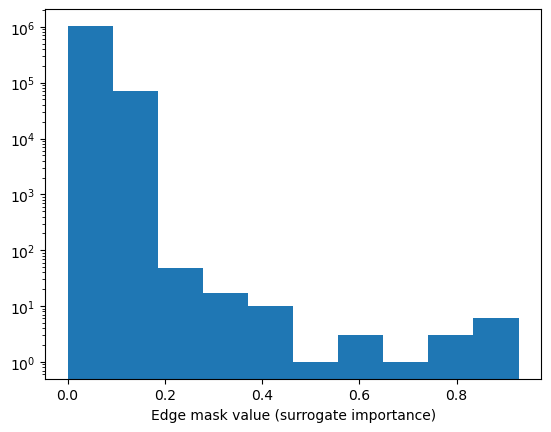

In [124]:
plt.figure()
plt.hist(explanation.edge_mask.cpu().numpy(), bins=10)
plt.yscale('log')
plt.xlabel('Edge mask value (surrogate importance)')
plt.show()

In [125]:
drugmeta = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')[['inhibitor', 'inchikey']].drop_duplicates()
inchi2name = drugmeta.set_index('inchikey').to_dict()['inhibitor']

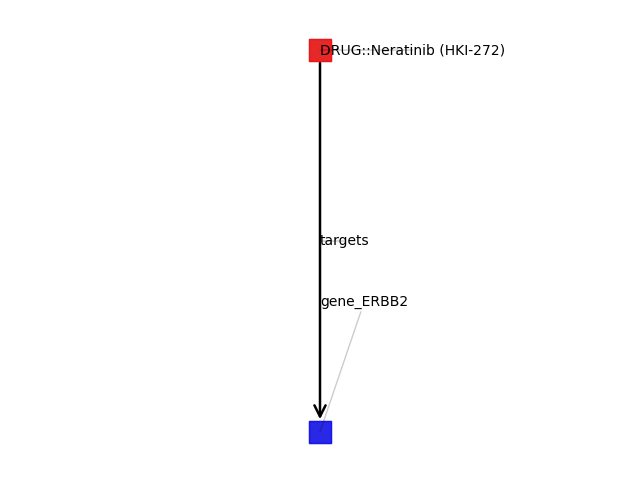

In [126]:

# ------------------------------
# 1) Build subgraph and edge masks
# ------------------------------
subgraph = explanation.get_explanation_subgraph()
mask_filter = subgraph.edge_mask > 0.5

sub_edge_index = subgraph.edge_index[:, mask_filter]
sub_edge_mask  = subgraph.edge_mask[mask_filter]

# Suppose you have sub_edge_type and sub_edge_name mapped already:
sub_edge_type = subgraph.edge_type[mask_filter].detach().cpu().numpy()
sub_edge_name = [
    x[1] for x in np.array(tdata.metadata()[1])[sub_edge_type]
]

# Collect node names
node_names = []
for ntype in tdata.metadata()[0]:
    if ntype == 'drug':
        node_names += [f'DRUG::{inchi2name.get(x)}' for x in tdata[ntype].names]
    else:
        node_names += [f'{ntype}_{x}' for x in tdata[ntype].names]
node_names = np.array(node_names)

# ------------------------------
# 2) Construct DiGraph & keep only path nodes
# ------------------------------
G = nx.DiGraph()

# Store "relation name" in the edge attributes
for ((src_idx, dst_idx), weight_val, rel_name) in zip(
    sub_edge_index.T, sub_edge_mask, sub_edge_name
):
    src_node = node_names[src_idx.item()]
    dst_node = node_names[dst_idx.item()]
    G.add_edge(
        src_node,
        dst_node,
        weight=float(weight_val),
        rel_name=rel_name
    )

# Only keep nodes on a path from src_node to targ_node
src_node = node_names[src_idx.item()]
targ_node = node_names[targ_idx.item()]

path_nodes = set()
for path in nx.all_simple_paths(G, source=src_node, target=targ_node):
    path_nodes.update(path)
G = G.subgraph(path_nodes)

# ------------------------------
# 3) Node Layout
# ------------------------------
pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=TB')

plt.figure(figsize=(8, 6))

# Draw nodes and edges without labels
sz = 250
_alpha = 0.75
nx.draw_networkx_nodes(G, pos, node_size=sz, node_color='gray', node_shape='s', alpha=_alpha)
nx.draw_networkx_nodes(G, pos, nodelist=[src_node], node_color='red', node_size=sz, node_shape='s', alpha=_alpha)
nx.draw_networkx_nodes(G, pos, nodelist=[targ_node], node_color='blue', node_size=sz, node_shape='s', alpha=_alpha)

edge_list = list(G.edges(data=True))
edge_widths = [d['weight'] * 2 for (_, _, d) in edge_list]
nx.draw_networkx_edges(
    G, pos,
    edgelist=edge_list,
    width=edge_widths,
    arrows=True,
    arrowstyle='->',
    node_size=sz * 1.33,
    arrowsize=20,
    alpha=1.0,
    #connectionstyle='arc3,rad=0.2'
)

# ------------------------------
# 4) Compute bounding box of all nodes
# ------------------------------
xs = [p[0] for p in pos.values()]
min_x, max_x = min(xs), max(xs)
graph_width = max_x - min_x if len(xs) > 1 else 1.0

# ---------------------------------------------------------------
# 5) Node Labels on the RIGHT
# ---------------------------------------------------------------
sorted_nodes = sorted(G.nodes(), key=lambda n: pos[n][1], reverse=True)
node_y_vals = [pos[n][1] for n in sorted_nodes]
max_y_node, min_y_node = max(node_y_vals), min(node_y_vals)
vertical_extent_node = (max_y_node - min_y_node) if len(sorted_nodes) > 1 else 1

n_nodes = len(sorted_nodes)
node_label_spacing = (0.1 if n_nodes <= 1
                      else 0.66 * (vertical_extent_node / (n_nodes - 1)))

# Place them at some fraction of the graph width beyond max_x
node_label_offset_x = max_x + 0.3 * graph_width

for i, n in enumerate(sorted_nodes):
    label_y = max_y_node - i * node_label_spacing
    plt.annotate(
        n,
        xy=pos[n],
        xytext=(node_label_offset_x, label_y),
        arrowprops=dict(
            arrowstyle="-",
            alpha=0.2,
            shrinkA=0,
            shrinkB=0,
            color='black'
        ),
        va='center',
        fontsize=10
    )

# ---------------------------------------------------------------
# 6) Edge Labels on the LEFT
# ---------------------------------------------------------------
# Compute midpoints for each edge
edge_midpoints = []
for (u, v, d) in edge_list:
    x_u, y_u = pos[u]
    x_v, y_v = pos[v]
    mid_x = (x_u + x_v) / 2.0
    mid_y = (y_u + y_v) / 2.0
    rel_name = d['rel_name']
    edge_midpoints.append((rel_name, mid_x, mid_y))

# Sort edge midpoints top-to-bottom (descending y)
edge_midpoints.sort(key=lambda x: x[2], reverse=True)
if edge_midpoints:
    edge_y_vals = [em[2] for em in edge_midpoints]
    max_y_edge, min_y_edge = max(edge_y_vals), min(edge_y_vals)
    vertical_extent_edge = max_y_edge - min_y_edge if len(edge_y_vals) > 1 else 1
else:
    vertical_extent_edge = 1

n_edges = len(edge_midpoints)
edge_label_spacing = (0.1 if n_edges <= 1
                      else 1.5 * (vertical_extent_edge / (n_edges - 1)))

# Offset on the left side
edge_label_offset_x = min_x - 0.33 * graph_width

for i, (rel_name, mx, my) in enumerate(edge_midpoints):
    label_y = max_y_edge - i * edge_label_spacing
    plt.annotate(
        rel_name,
        xy=(mx, my),
        xytext=(edge_label_offset_x, label_y),
        arrowprops=dict(
            arrowstyle="-",
            alpha=0.2,
            shrinkA=0,
            shrinkB=0,
            color='black'
        ),
        va='center',
        fontsize=10
    )

plt.margins(x=0.1)
plt.axis('off')
plt.show()


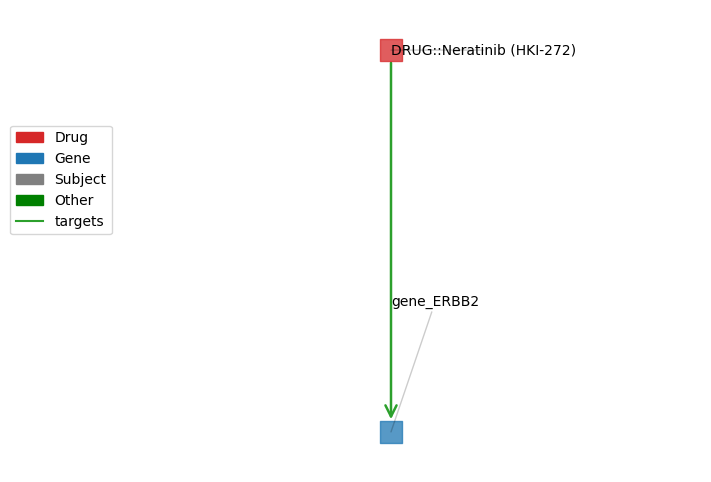

In [127]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# ------------------------------
# 1) Build subgraph and edge masks
# ------------------------------
subgraph = explanation.get_explanation_subgraph()
mask_filter = subgraph.edge_mask > 0.5

sub_edge_index = subgraph.edge_index[:, mask_filter]
sub_edge_mask  = subgraph.edge_mask[mask_filter]

# Suppose you have sub_edge_type and sub_edge_name mapped already:
sub_edge_type = subgraph.edge_type[mask_filter].detach().cpu().numpy()
sub_edge_name = [
    x[1] for x in np.array(tdata.metadata()[1])[sub_edge_type]
]

# Collect node names
node_names = []
for ntype in tdata.metadata()[0]:
    if ntype == 'drug':
        # Convert InChI -> name for readability
        node_names += [f'DRUG::{inchi2name.get(x)}' for x in tdata[ntype].names]
    else:
        node_names += [f'{ntype}_{x}' for x in tdata[ntype].names]
node_names = np.array(node_names)

# ------------------------------
# 2) Construct DiGraph & keep only path nodes
# ------------------------------
G = nx.DiGraph()

for ((src_idx, dst_idx), weight_val, rel_name) in zip(
    sub_edge_index.T, sub_edge_mask, sub_edge_name
):
    src_node = node_names[src_idx.item()]
    dst_node = node_names[dst_idx.item()]
    G.add_edge(
        src_node,
        dst_node,
        weight=float(weight_val),
        rel_name=rel_name
    )

# Only keep nodes on a path from src_node to targ_node
src_node = node_names[src_idx.item()]
targ_node = node_names[targ_idx.item()]

path_nodes = set()
for path in nx.all_simple_paths(G, source=src_node, target=targ_node):
    path_nodes.update(path)
G = G.subgraph(path_nodes)

# ------------------------------
# 3) Node Layout (Graphviz)
# ------------------------------
pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=TB')

plt.figure(figsize=(8, 6))

# ------------------------------
# 4) Color Nodes by Type
# ------------------------------
# We'll define a small function to extract a node "type" from its name
def get_node_type(n):
    if n.startswith("DRUG::"):
        return "Drug"
    elif n.startswith("gene_"):
        return "Gene"
    elif n.startswith("dbgap_subject_"):
        return "Subject"
    else:
        return "Other"  # fallback

# Define a color for each node type
node_type_colors = {
    "Drug":    "#d62728",  # red
    "Gene":    "#1f77b4",  # blue
    "Subject": "gray",
    "Other":   "green"
}

# Build a parallel list of node colors in the same order as G.nodes()
node_colors = []
for n in G.nodes():
    ntype = get_node_type(n)
    node_colors.append(node_type_colors[ntype])

# We'll draw nodes in one go, providing the `node_color` array
nx.draw_networkx_nodes(
    G, pos,
    node_size=250,
    node_color=node_colors,  # Provide the color for each node
    node_shape='s',
    alpha=0.75
)

# ------------------------------
# Highlight the specific src/targ node if you like
# (But they already get their color from the dictionary.)
# If you want to override that color for just these two nodes:
# nx.draw_networkx_nodes(...)

# ------------------------------
# 5) Color Edges by "rel_name"
# ------------------------------
# Collect edges & their attributes
edge_list = list(G.edges(data=True))
edge_widths = [d['weight'] * 2 for (_, _, d) in edge_list]

# We can build a color map for each edge type
edge_color_map = {}
palette = [
    "#2ca02c", "#ff7f0e", "#9467bd", "#8c564b", "#e377c2",
    "#7f7f7f", "#bcbd22", "#17becf"
]  # or pick your own set of colors
color_idx = 0

edge_colors = []
for (u, v, d) in edge_list:
    rel = d['rel_name']
    if rel not in edge_color_map:
        # Assign a color from the palette, or cycle through if we run out
        edge_color_map[rel] = palette[color_idx % len(palette)]
        color_idx += 1
    edge_colors.append(edge_color_map[rel])

nx.draw_networkx_edges(
    G, pos,
    edgelist=edge_list,
    width=edge_widths,
    arrows=True,
    arrowstyle='->',
    node_size=250 * 1.33,
    arrowsize=20,
    alpha=1.0,
    edge_color=edge_colors  # key line: color each edge by its rel_name
)

# ------------------------------
# 6) Node Labels on the Right
# ------------------------------
# We'll keep your bounding-box logic to place node labels nicely to the right.
xs = [p[0] for p in pos.values()]
min_x, max_x = min(xs), max(xs)
graph_width = max_x - min_x if len(xs) > 1 else 1.0

sorted_nodes = sorted(G.nodes(), key=lambda n: pos[n][1], reverse=True)
node_y_vals = [pos[n][1] for n in sorted_nodes]
max_y_node, min_y_node = max(node_y_vals), min(node_y_vals)
vertical_extent_node = (max_y_node - min_y_node) if len(sorted_nodes) > 1 else 1

n_nodes = len(sorted_nodes)
node_label_spacing = (0.1 if n_nodes <= 1
                      else 0.66 * (vertical_extent_node / (n_nodes - 1)))

# Place them a fraction of graph_width beyond max_x
node_label_offset_x = max_x + 0.3 * graph_width

for i, n in enumerate(sorted_nodes):
    label_y = max_y_node - i * node_label_spacing
    plt.annotate(
        n,
        xy=pos[n],
        xytext=(node_label_offset_x, label_y),
        arrowprops=dict(
            arrowstyle="-",
            alpha=0.2,
            shrinkA=0,
            shrinkB=0,
            color='black'
        ),
        va='center',
        fontsize=10
    )

# ------------------------------
# 7) Build and Show a Legend
# ------------------------------
# Legend for node types
node_legend_handles = []
for node_t, color in node_type_colors.items():
    patch = mpatches.Patch(color=color, label=node_t)
    node_legend_handles.append(patch)

# Legend for edge types
edge_legend_handles = []
for rel, color in edge_color_map.items():
    line = mlines.Line2D([], [], color=color, label=rel)
    edge_legend_handles.append(line)

# Combine and draw
plt.legend(
    handles=node_legend_handles + edge_legend_handles,
    bbox_to_anchor=(0.05, 0.75), borderaxespad=0.
)

plt.margins(x=0.1)
plt.axis('off')
plt.show()
